<a href="https://colab.research.google.com/github/invegat/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=185.83079331571034, mobile=True), User(purchased=False, time_on_site=298.33620711793867, mobile=True), User(purchased=False, time_on_site=152.89962976026965, mobile=True), User(purchased=False, time_on_site=213.29214967364368, mobile=True), User(purchased=False, time_on_site=147.99920093200328, mobile=False), User(purchased=False, time_on_site=239.57400495583042, mobile=True), User(purchased=False, time_on_site=34.85253101974771, mobile=True), User(purchased=False, time_on_site=23.320690657542162, mobile=True), User(purchased=False, time_on_site=6.987572043247107, mobile=True), User(purchased=False, time_on_site=234.37099949788518, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,185.830793,True
1,False,298.336207,True
2,False,152.899630,True
3,False,213.292150,True
4,False,147.999201,False


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.267339426390596,5.440407727504178,5.5400255343161025,6.539238198723032,6.56734372239138,6.892151977252064,6.987572043247107,7.1026878684275045,7.244240385484813,7.635859661715855,...,574.3557255707063,576.1342942162283,577.9533966413683,583.656329686723,584.2151365376217,585.8018607010143,586.9664237118478,591.1520678201244,595.5107670014609,596.07879640076
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,0,1,1,1,1,1,1,...,0,1,1,1,1,1,0,1,1,1
True,0,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.677, 123.43]","(123.43, 241.592]","(241.592, 359.754]","(359.754, 477.917]","(477.917, 596.079]"
purchased,,,,,
False,278,259,169,36,54
True,71,75,46,7,5


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.677, 123.43]","(123.43, 241.592]","(241.592, 359.754]","(359.754, 477.917]","(477.917, 596.079]"
purchased,,,,,
False,0.796562,0.775449,0.786047,0.837209,0.915254
True,0.203438,0.224551,0.213953,0.162791,0.084746


In [8]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.892,0.764
True,0.108,0.236


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [10]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/invegat/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv", index_col=0)
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [11]:
print(f"age type {df['age'].dtype} exercise_time type {df['exercise_time'].dtype} weight type {df['weight'].dtype}")

age type int64 exercise_time type int64 weight type int64


In [12]:
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline
# print(s_data[['X2', 'X3']].shape,s_data['X1'].shape)
model = LinearRegression().fit(df[['age', 'exercise_time']], df['weight'])
coef_ = model.coef_
print('𝛽₁: {}  𝛽₂: {}  𝛽₀ {}   𝛽₁/𝛽₂ percent '.format(coef_[0], coef_[1], model.intercept_), coef_[0] * 100 /math.fabs(coef_[1]))

𝛽₁: 0.027757747890820143  𝛽₂: -0.19469397500409089  𝛽₀ 178.463777274025   𝛽₁/𝛽₂ percent  14.25711704239276


In [0]:
X2, X3 = np.meshgrid(df['age'], df['exercise_time'])

def f(x,y):
  z = coef_[0] * x + coef_[1] * y + model.intercept_
  return z

X1 = f(X2, X3)

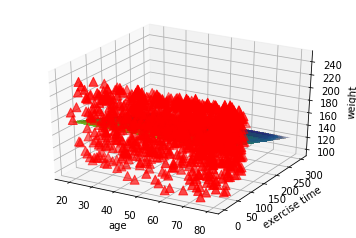

In [14]:
ax = plt.axes(projection='3d')
ax.plot_surface(X2, X3, X1, rstride=10, cstride=10, 
                cmap='viridis', edgecolor=None, alpha=0.01)
ax.scatter(df['age'],df['exercise_time'], df['weight'], c='r', marker='^', s=80)
ax.set_xlabel('age')
ax.set_ylabel('exercise time')
ax.set_zlabel('weight')
plt.show()

In [15]:
# !pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


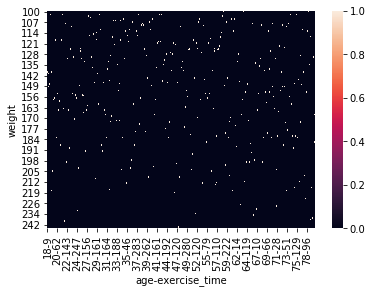

In [18]:
import seaborn as sns
ct = pd.crosstab(df['weight'], [df['age'], df['exercise_time']])
sns.heatmap(ct);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
###age type int64 exercise_time type int64 weight type int64
2.  What are the relationships between the variables?
###I used age and execise_time as the independate variables and  weight as the dependant variable
3.  Which relationships are "real", and which spurious?
###exercise_time is real, age is mostly spurious (only 14% as important as exercise_time).

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)